In [1]:
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange
from torch import nn

In [2]:
import torch
from transformers import BertModel

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(device))
    torch.cuda.empty_cache()
else:
    print('Failed to find GPU. Will use CPU.')
    device = 'cpu'

Current device: Xavier


In [3]:
from utils.Constants import tokenizer, PRE_TRAINED_MODEL_NAME
from dataLoader.DataLoader import get_data_loader
from dataLoader.DataLoaderUtils import get_question_answers_for_where_value_def_length, get_question_answers_def_length

dev_data_loader = get_data_loader(data_type = 'dev', tokenizer = tokenizer, batch_size = 1)

  0%|          | 6/8421 [00:00<02:20, 59.94it/s]

We have 8421 dev data with 2716 tables.


100%|██████████| 8421/8421 [02:17<00:00, 61.40it/s]


In [4]:
from models.QABert import QABertTrainer
from models.SelectRanker import SelectRankerTrainer
from models.WhereRanker import WhereRankerTrainer
from models.WhereConditionClassifier import WhereConditionClassifierTrainer
from models.WhereNumberClassifier import WhereNumberClassifierTrainer
from models.AggregationClassifier import AggregationClassifierTrainer
from train.Trainer import train_epoch, save_model, load_model

bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
for param in bert.parameters():
    param.requires_grad = False

models = dict(
    selection_trainer = SelectRankerTrainer(device, dev_data_loader, bert),
    agg_class_trainer = AggregationClassifierTrainer(device, dev_data_loader, bert, use_pretrained=False),
    where_ranker_trainer = WhereRankerTrainer(device, dev_data_loader, bert),
    where_cond_class_trainer = WhereConditionClassifierTrainer(device, dev_data_loader, bert, use_pretrained=False),
    where_numb_class_trainer = WhereNumberClassifierTrainer(device, dev_data_loader, bert),
    qa_trainer = QABertTrainer(device, dev_data_loader, bert, use_pretrained=False),
)

In [5]:
from train.Trainer import train_epoch, save_model, load_model

#models = load_model("./checkpoint/16_Mar_2021_19_21", dev_data_loader, device)
train_epoch(models, dev_data_loader, device)
save_model(models,"./checkpoint")

100%|██████████| 8421/8421 [1:13:47<00:00,  1.90batch/s]


Subpath: 17_Mar_2021_20_59
Saving selection_trainer under ./checkpoint/17_Mar_2021_20_59/selection_trainer.ckpt
Saving agg_class_trainer under ./checkpoint/17_Mar_2021_20_59/agg_class_trainer.ckpt
Saving where_ranker_trainer under ./checkpoint/17_Mar_2021_20_59/where_ranker_trainer.ckpt
Saving where_cond_class_trainer under ./checkpoint/17_Mar_2021_20_59/where_cond_class_trainer.ckpt
Saving where_numb_class_trainer under ./checkpoint/17_Mar_2021_20_59/where_numb_class_trainer.ckpt
Saving qa_trainer under ./checkpoint/17_Mar_2021_20_59/qa_trainer.ckpt


In [28]:
import json

losses = {
    f'{key}_loss': [loss if type(loss) == int or type(loss) == float else loss.item() for loss in value.losses] for key, value in models.items()
}
# losses['qa_trainer_loss']
with open('data/losses.json', 'w') as outfile:
    json.dump(losses, outfile)

In [21]:
models['qa_trainer'].losses[0].item()

4.370214462280273

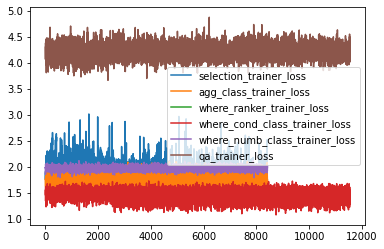

In [33]:
from matplotlib.pyplot import plot

for key, loss in losses.items():
    plot(loss, label=key)
plt.legend()
plt.show()